## Import modules

In [1]:
from pathlib import Path

import requests
import zipfile
import io

import pandas as pd
import numpy as np

import joblib

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import BallTree
from sklearn.metrics import silhouette_score

from kneed import KneeLocator

from utils import (unpack_datetime, UnpackWhat)

# Earth's radius / kilometers in one radian
EARTH_RADIUS_KM = 6371.0

pio.renderers.default = "jupyterlab+png"

## Recupération des data

In [2]:
# URL of the ZIP file
JEDHA_DATASET_URL = "https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Machine+Learning+non+Supervis%C3%A9/Projects/uber-trip-data.zip"

# base DATA folder
DATA_BASE_DIR = Path.joinpath(Path.cwd(), 'data')
DATA_BASE_DIR.mkdir(exist_ok=True)

# raw data folder
RAW_DATA_DIR = DATA_BASE_DIR / "raw"
RAW_DATA_DIR.mkdir(exist_ok=True)

# if nothing in raw folder, download and unzip JEDHA dataset archive
if not any(RAW_DATA_DIR.iterdir()):
    print("RAW data folder is empty. Downloading and extracting data...")

    response = requests.get(JEDHA_DATASET_URL)
    response.raise_for_status()  # Ensure the request was successful

    # print("Unzipping the contents...")
    # with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    #     zip_ref.extractall(DATA_BASE_DIR)


    # Just extract the content of 'uber-trip-data/' folder
    print("Extracting 'uber-trip-data/' contents...")
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        for member in zip_ref.namelist():
            if member.startswith("uber-trip-data/") and not member.endswith("/"):
                # Extract into our destination directory (removing the top folder name)
                relative_path = Path(member).relative_to("uber-trip-data")
                target_path = RAW_DATA_DIR / relative_path
                target_path.parent.mkdir(parents=True, exist_ok=True)
                with zip_ref.open(member) as source, open(target_path, "wb") as target:
                    target.write(source.read())

    print(f"Extraction completed. Files are in: {RAW_DATA_DIR.resolve()}")
else:
    print(f"RAW data folder is not empty. Skipping download. Contents already exist in: {RAW_DATA_DIR.resolve()}")
    
# Lister les fichiers extraits
print("\nListe des fichiers disponibles :")
for path in RAW_DATA_DIR.rglob("*"):
    if path.is_file():
        print(f"- {path.relative_to(RAW_DATA_DIR)}")

RAW data folder is not empty. Skipping download. Contents already exist in: /workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw

Liste des fichiers disponibles :
- taxi-zone-lookup.csv
- uber-raw-data-apr14.csv
- uber-raw-data-aug14.csv
- uber-raw-data-janjune-15.csv.zip
- uber-raw-data-jul14.csv
- uber-raw-data-jun14.csv
- uber-raw-data-may14.csv
- uber-raw-data-sep14.csv


## Chargement des données

In [3]:
raw_data_files_2014 = [file for file in RAW_DATA_DIR.glob('uber-raw-data*.csv')]
raw_data_files_2014.sort()

print("Nb of files: ", len(raw_data_files_2014))
print(raw_data_files_2014)

Nb of files:  6
[PosixPath('/workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw/uber-raw-data-apr14.csv'), PosixPath('/workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw/uber-raw-data-aug14.csv'), PosixPath('/workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw/uber-raw-data-jul14.csv'), PosixPath('/workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw/uber-raw-data-jun14.csv'), PosixPath('/workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw/uber-raw-data-may14.csv'), PosixPath('/workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw/uber-raw-data-sep14.csv')]


In [4]:
# Load N file (1 to 6)
NB_FILES_TO_LOAD = 6

raw_data_df = pd.concat(map(pd.read_csv, raw_data_files_2014[0:NB_FILES_TO_LOAD]))

# normalize column names
raw_data_df.columns = ['date_time', 'lat', 'lon', 'base']

# Convert datetime
raw_data_df['date_time'] = pd.to_datetime(raw_data_df['date_time'])

# Unpack datetime
unpack_datetime(raw_data_df, 'date_time', UnpackWhat.ALL, prefix='dt', inplace=True)

# Pour réduire/recentrer les datas on va appliquer un filtrage des outliers aux colonnes latitude et longitude
print("Initial shape: ", raw_data_df.shape)

for col in ["lat", "lon"] :
    col_mean = raw_data_df[col].mean()
    col_std = raw_data_df[col].std()
    range_min = col_mean - 3 * col_std
    range_max = col_mean + 3 * col_std
  
    raw_data_df = raw_data_df[(raw_data_df[col] > range_min) & (raw_data_df[col] <= range_max)]
    
print("New Shape: ", raw_data_df.shape)

Initial shape:  (4534327, 14)
New Shape:  (4301626, 14)


## Clustering

### Exploration sur un jeu de données restreint

#### Préparation du dataset de test

In [5]:
# Let analyze 18h on first thursday of September
month = 9 # September
weekday = 3 # Thursday
hour = 18
day = raw_data_df[(raw_data_df["dt_month"] == month) & (raw_data_df["dt_weekday"] == weekday)]["dt_day"].unique()[0]

assess_hour_df = raw_data_df[(raw_data_df["dt_month"] == month) & (raw_data_df["dt_weekday"] == weekday) & (raw_data_df["dt_hour"] == hour)]["dt_day"].unique()[0]

# Keep hourly rides
assess_hour_df  = raw_data_df[(raw_data_df["dt_month"] == month) & (raw_data_df["dt_day"] == day) & (raw_data_df["dt_hour"] == hour)]

assess_hour_df.shape

(2949, 14)

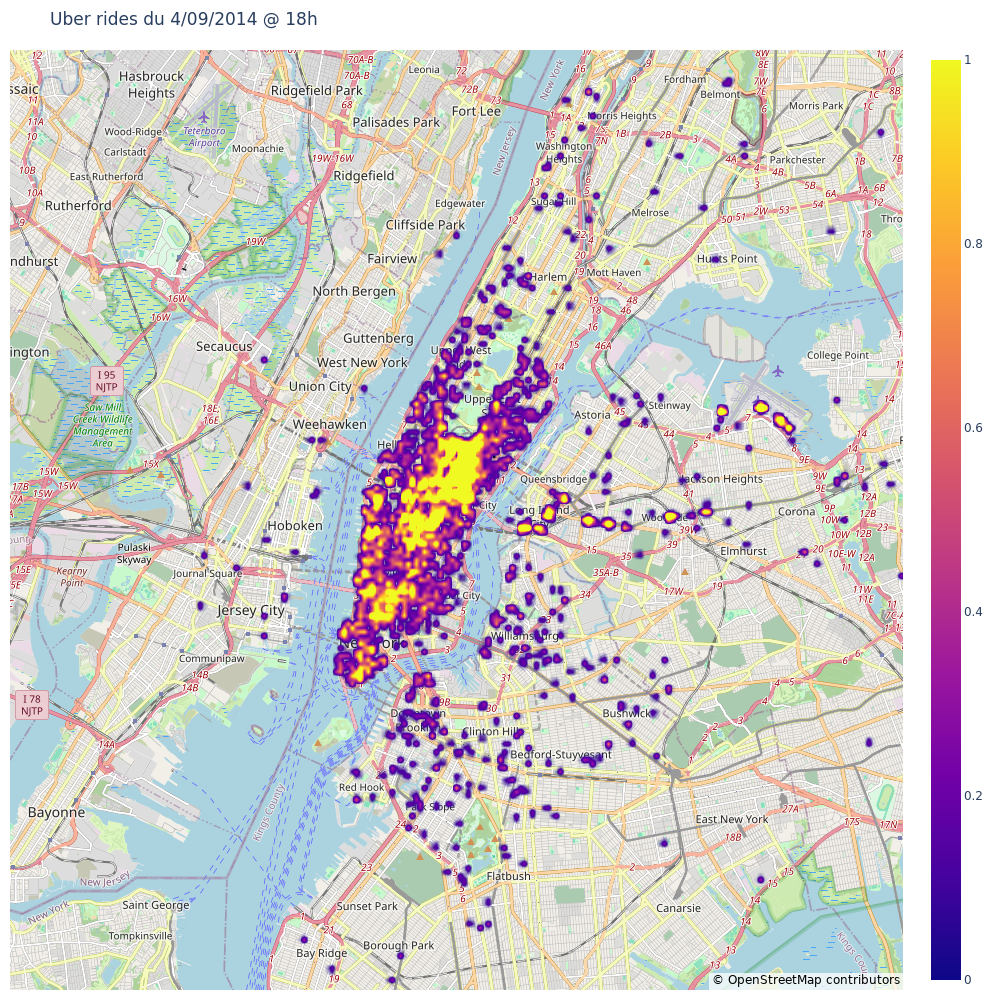

In [6]:
# Base map settings
mapbox_style = "open-street-map" #"carto-positron"
mapbox_center = {"lat": assess_hour_df["lat"].mean(), "lon": assess_hour_df["lon"].mean()}
    
fig_hour = px.density_map(
    assess_hour_df,
    lat="lat",
    lon="lon",
    z=None,
    radius=5,
    center=mapbox_center,
    zoom=11,
    map_style=mapbox_style,
    title= f"Uber rides du {day}/{month:02d}/{assess_hour_df['dt_year'].unique()[0]} @ {hour}h"
)

fig_hour.update_layout(
    margin=dict(l=10, r=10, t=50, b=10),
)

fig_hour.update_layout(height=1000, width=1000)

fig_hour.show()


#### K-Means

In [7]:
# Prepare dataset
# 1. select features
kmeans_df = assess_hour_df[["lat", "lon"]]

# 2. standardize data
scaler = StandardScaler()
X_kmeans_df = scaler.fit_transform(kmeans_df)

# K range to test
K_range = range(2, 15) # K=1 has no silhouette score

wcss = [] # Within-Cluster Sum of Square
silhouette = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 'auto')
    kmeans.fit(X_kmeans_df)
    
    # log metrics
    wcss.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_kmeans_df, kmeans.predict(X_kmeans_df)))


kmeans_cluster_df = pd.DataFrame({'nb_clusters' : K_range , 'wcss' : wcss, 'silhouette' : silhouette}).set_index('nb_clusters').reset_index()

display(kmeans_cluster_df)

nb_clusters         wcss  silhouette
0             2  3821.784584    0.511809
1             3  2293.220554    0.459842
2             4  1732.296914    0.446091
3             5  1442.658166    0.358387
4             6  1187.948553    0.388308
5             7  1083.854398    0.393745
6             8   823.762701    0.417538
7             9   786.657707    0.369418
8            10   746.652895    0.355594
9            11   643.064257    0.367331
10           12   611.571027    0.367167
11           13   579.025926    0.360052
12           14   530.587151    0.361993

##### Elbow vs Silhouette

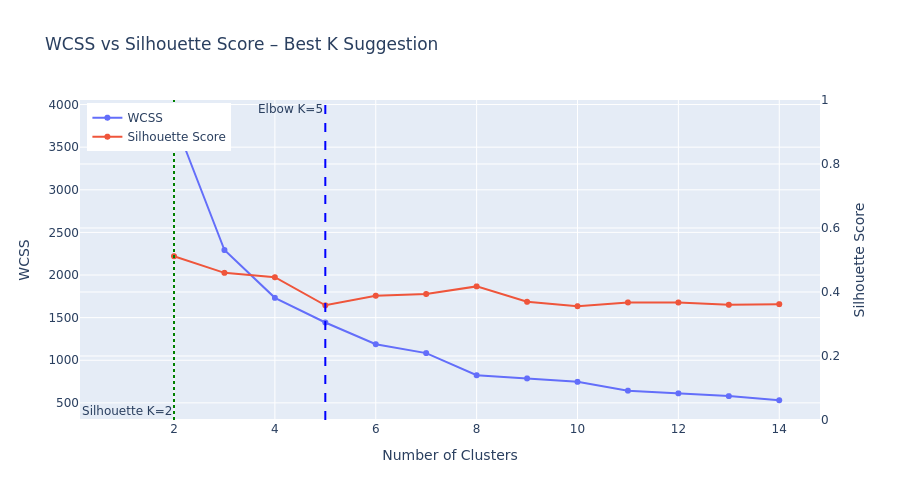

In [8]:
# Détection du coude
kl = KneeLocator(kmeans_cluster_df["nb_clusters"], kmeans_cluster_df["wcss"], curve="convex", direction="decreasing")
best_k_elbow = kl.elbow

# K avec meilleur score silhouette
best_k_silhouette = kmeans_cluster_df.loc[kmeans_cluster_df["silhouette"].idxmax(), "nb_clusters"]

# Création du graphique
fig = go.Figure()

# Courbe WCSS
fig.add_trace(go.Scatter(
    x=kmeans_cluster_df["nb_clusters"], y=kmeans_cluster_df["wcss"],
    mode="lines+markers", name="WCSS", yaxis="y1"
))

# Courbe Silhouette
fig.add_trace(go.Scatter(
    x=kmeans_cluster_df["nb_clusters"], y=kmeans_cluster_df["silhouette"],
    mode="lines+markers", name="Silhouette Score", yaxis="y2"
))

# Lignes verticales pour les meilleurs K
fig.add_vline(x=best_k_elbow, line=dict(color="blue", dash="dash"), annotation_text=f"Elbow K={best_k_elbow}", annotation_position="top left")
fig.add_vline(x=best_k_silhouette, line=dict(color="green", dash="dot"), annotation_text=f"Silhouette K={best_k_silhouette}", annotation_position="bottom left")

# Mise en page
fig.update_layout(
    title="WCSS vs Silhouette Score – Best K Suggestion",
    xaxis=dict(title="Number of Clusters"),
    yaxis=dict(title="WCSS", side="left"),
    yaxis2=dict(title="Silhouette Score", overlaying="y", side="right", range=[0, 1]),
    legend=dict(x=0.01, y=0.99),
    width=900,
    height=500
)

fig.show()

Les 2 méthodes ne sont pas d'accord, cependant, au regard du problème, il semble préférable de partir sur 5 clusters.

In [9]:
# features
kmeans_df = assess_hour_df[["lat", "lon"]]
# standardized data
X_kmeans_df = scaler.fit_transform(kmeans_df)

# Best K
K_optimal = 5

kmeans = KMeans(n_clusters=K_optimal, random_state=42, n_init = 'auto')
    
assess_hour_and_cluster_df = assess_hour_df.copy()
assess_hour_and_cluster_df["kmeans_cluster"] = kmeans.fit_predict(X_kmeans_df)
assess_hour_and_cluster_df["kmeans_cluster_k"] = K_optimal

# Store cluster centroids (need to inverse scale of centroids)
centroids_scaled = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)

kmeans_cluster_centroids_df = pd.DataFrame(centroids_original, columns=['lat', 'lon'])

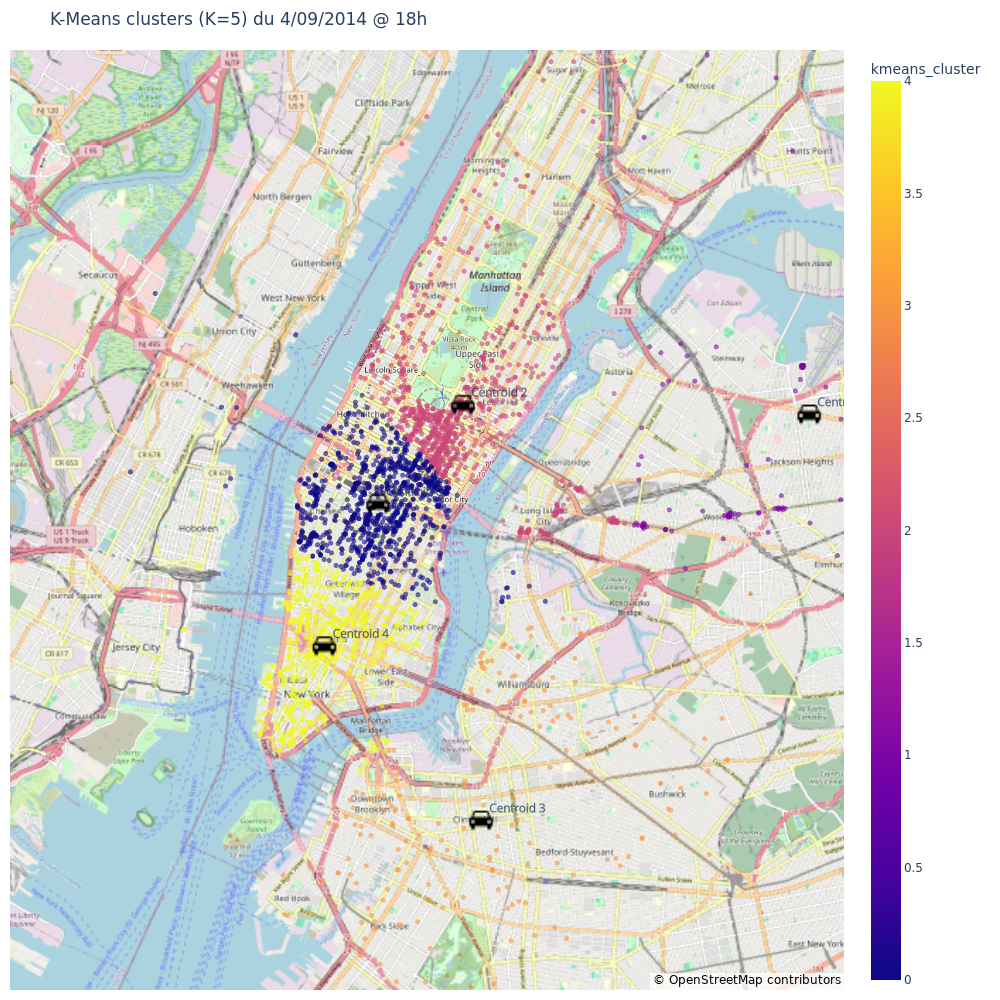

In [10]:
# Base map settings
mapbox_style = "open-street-map" #"carto-positron"
mapbox_center = {"lat": assess_hour_and_cluster_df["lat"].mean(), "lon": assess_hour_and_cluster_df["lon"].mean()}
    
# Les rides colorées par cluster    
fig_hour = px.scatter_map(
    assess_hour_and_cluster_df,
    lat="lat",
    lon="lon",
    opacity = 0.6,
    color="kmeans_cluster",
    # radius=5,
    center=mapbox_center,
    zoom=11.5,
    map_style=mapbox_style,
    title= f"K-Means clusters (K={assess_hour_and_cluster_df['kmeans_cluster_k'].unique()[0]}) du {day}/{month:02d}/{assess_hour_and_cluster_df['dt_year'].unique()[0]} @ {hour}h"
)

fig_hour.add_trace(go.Scattermap(
    lat=kmeans_cluster_centroids_df["lat"],
    lon=kmeans_cluster_centroids_df["lon"],
    mode="markers+text",
    marker=dict(
        size=18,
        color="black",
        symbol="car"
    ),
    # name="",
    showlegend=False,
    text=[f"Centroid {i}" for i in kmeans_cluster_centroids_df.index],
    textposition="top right",
    subplot="map"
))

fig_hour.update_layout(
    margin=dict(l=10, r=10, t=50, b=10),
)

fig_hour.update_layout(height=1000, width=1000)

fig_hour.show()

Les clusters sont trés centrés sur les zones de forte densité de courses.